In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook

In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

%aimport mre_pinn

Loading /mnt/c/Users/mtr22/Code/MRE-PINN/mre_pinn/__init__.py


# Traveling wave forward problem

The linear viscoelastic wave equation is as follows:

$$
\begin{align}
    \nabla \cdot \sigma &= \rho \mathbf{u}_{tt}
\end{align}
$$

Where strain is defined as:

$$
\begin{align}
    \sigma &= \mu \left( \nabla \mathbf{u} + (\nabla \mathbf{u})^\top \right) + \lambda (\nabla \cdot \mathbf{u}) \mathbf{I}
\end{align}
$$

We can discretize as follows:


$$
\begin{align}
    \nabla \cdot \sigma^k &= \rho \frac{\mathbf{u}^{k+1} - 2 \mathbf{u}^k + \mathbf{u}^{k-1}}{dt^2} \\
    \frac{dt^2}{\rho} \nabla \cdot \sigma^k &= \mathbf{u}^{k+1} - 2 \mathbf{u}^k + \mathbf{u}^{k-1} \\
    \mathbf{u}^{k+1} &= \frac{dt^2}{\rho} \nabla \cdot \sigma^k + 2 \mathbf{u}^k - \mathbf{u}^{k-1} \\
\end{align}
$$

Which we can solve once we provide sufficient initial and boundary conditions.

201 101 101


<IPython.core.display.Javascript object>


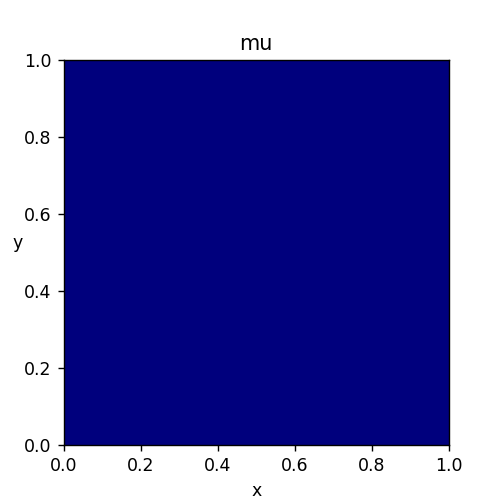

In [4]:
# temporal resolution

len_t =  1 # seconds
dt = 0.005 # seconds
n_t = int(len_t / dt + 1)

# spatial resolution

len_x = 1 # meters
dx = 0.01 # meters
n_x = int(len_x / dx + 1)

len_y = 1 # meters
dy = 0.01 # meters
n_y = int(len_y / dy + 1)

print(n_t, n_x, n_y)

# physical parameters

rho = 1 # kilogram / meter^2
omega = 4 * (2 * np.pi) # radians
mu_back = 1
lam_back = 1000

# disk-shaped inclusion

mu_disk = 1
lam_disk = lam_back
loc = (0.5, 0.5)
radius = 0.2

mu  = np.full((n_x, n_y), mu_back)
lam = np.full((n_x, n_y), lam_back)

x = np.linspace(0, len_x, n_x)
y = np.linspace(0, len_y, n_y)
x, y = np.meshgrid(x, x)
dist = np.sqrt((x - loc[0])**2 + (y - loc[1])**2)
disk = np.exp(-(dist/radius)**8)
mu  = mu + disk * (mu_disk - mu_back)
lam = mu + disk * (lam_disk - lam_back)

# display elasticity field

def view2d(a, len_x, len_y, title, ax, **kwargs):
    extent = (0, len_x, 0, len_y)
    im = ax.imshow(a, extent=extent, resample=False, **kwargs)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y', rotation=0)
    return im

e_map = mre_pinn.visual.elast_color_map()
e_min =  0
e_max = 10

fig, ax = plt.subplots(1, 1, figsize=(4*len_x, 4*len_y))
view2d(mu, len_x, len_y, title='mu', ax=ax, vmin=e_min, vmax=e_max, cmap=e_map)

In [5]:
%%time

import tqdm

# simulate wave field
u = np.zeros((n_t, n_x, n_y, 2))

nax = np.newaxis
for k in tqdm.tqdm(range(n_t-1)):
    
    # boundary conditions
    t = k * dt
    if omega * t < 2*np.pi:
        u[k,0,:,0] = np.sin(omega*t)
    else:
        u[k,0,:,0] = 0
    u[k,0,:,1]  = 0
    u[k,-1,:,:] = 0
    u[k,:,0,:]  = u[k,:,-2,:]
    u[k,:,-1,:] = u[k,:,1,:]
    
    if k < 1: # need two initial time steps
        continue
    
    # forward step
    grad_ux = np.stack(np.gradient(u[k,...,0]), axis=-1) / dx
    grad_uy = np.stack(np.gradient(u[k,...,1]), axis=-1) / dx
    
    jac_u = np.stack([grad_ux, grad_uy], axis=-2)
    jac_u_T = np.transpose(jac_u, axes=(0,1,3,2))
    div_u = grad_ux[...,0] + grad_uy[...,1]
    
    I = np.eye(2).reshape(1,1,2,2)
    
    s = mu[...,nax,nax] * (jac_u + jac_u_T) + lam[...,nax,nax] * div_u[...,nax,nax] * I
    
    grad_sxx_x = np.gradient(s[...,0,0], axis=0) / dx
    grad_sxy_y = np.gradient(s[...,0,1], axis=1) / dy
    grad_syx_x = np.gradient(s[...,1,0], axis=0) / dx
    grad_syy_y = np.gradient(s[...,1,1], axis=1) / dy
    div_s = np.stack([grad_sxx_x + grad_sxy_y, grad_syx_x + grad_syy_y], axis=-1)

    u[k+1] = dt**2 / rho * div_s + 2 * u[k] - u[k-1]

#u += np.random.normal(0, 0.05, u.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 316.19it/s]

CPU times: user 578 ms, sys: 78.1 ms, total: 656 ms
Wall time: 656 ms


<IPython.core.display.Javascript object>


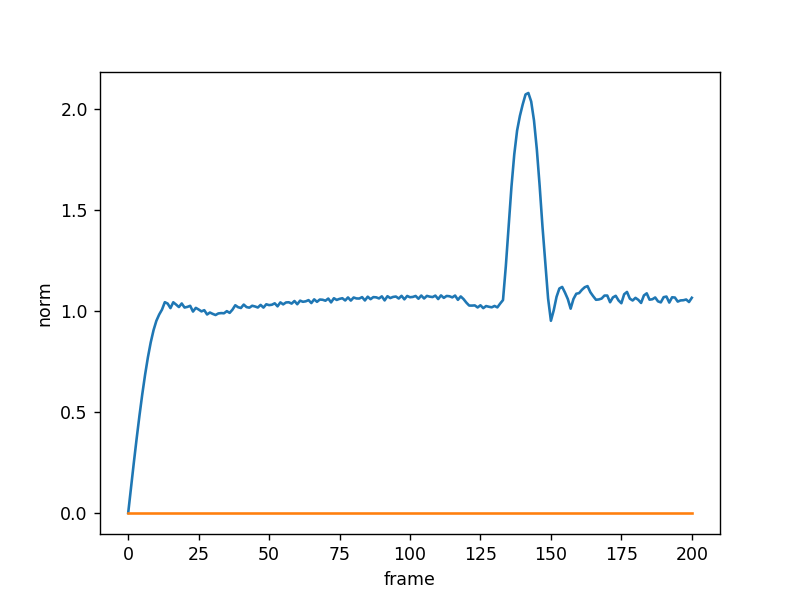

In [6]:
norm = lambda x: np.abs(x).max()

norm_uxs = []
norm_uys = []

for k in range(n_t):
    norm_ux = norm(u[k,...,0])
    norm_uy = norm(u[k,...,1])
    norm_uxs.append(norm_ux)
    norm_uys.append(norm_uy)

plt.figure()
plt.plot(norm_uxs, label='$u_x$')
plt.plot(norm_uys, label='$u_y$')
plt.ylabel('norm')
plt.xlabel('frame')
plt.show()

<IPython.core.display.Javascript object>


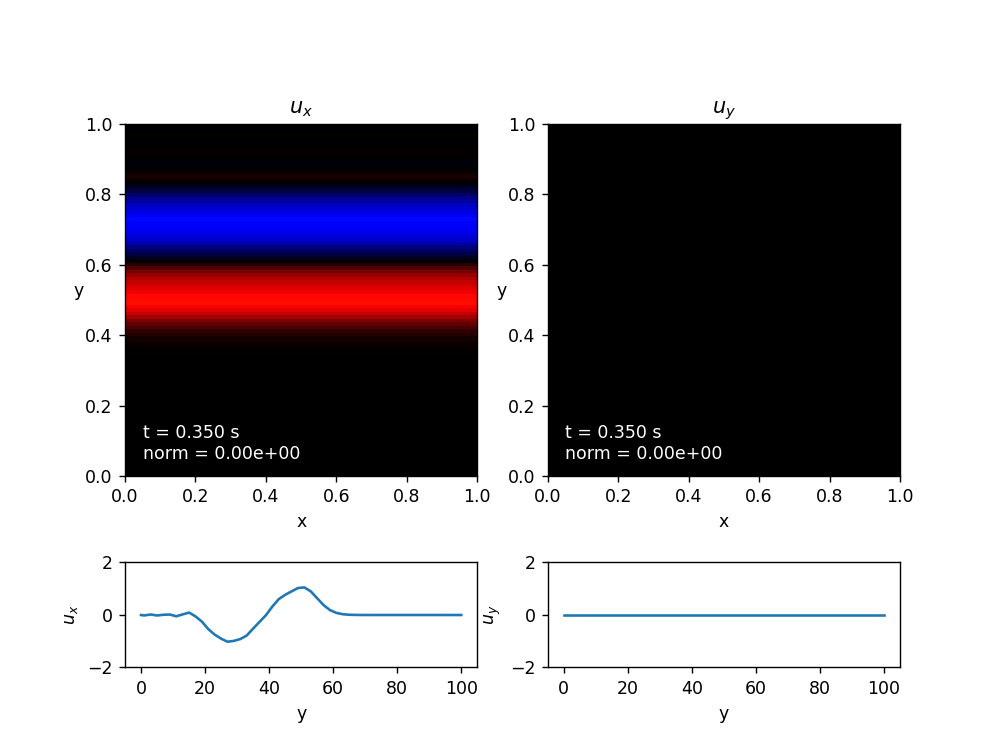

In [14]:
from matplotlib import animation

# display wave field simulation

def view1d(u, len_x, ylim, ylabel, ax, **kwargs):
    line, = ax.plot(u, **kwargs)
    ax.set_ylim(*ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('y')
    return line

def view_sim(u, len_x, len_y):

    w_map = mre_pinn.visual.wave_color_map()
    w_min = -2
    w_max =  2
    mid = n_x // 2

    fig, axes = plt.subplots(2, 2, figsize=(8,6), gridspec_kw=dict(height_ratios=[8, 2]))

    txt_ux = axes[0,0].text(0.05, 0.05, f't = 0 s\nnorm = 0', color='white', bbox=dict(facecolor='black', alpha=0.5))
    txt_uy = axes[0,1].text(0.05, 0.05, f't = 0 s\nnorm = 0', color='white', bbox=dict(facecolor='black', alpha=0.5))
    im_ux2 = view2d(u[0,...,0], len_x, len_y, ax=axes[0,0], title='$u_x$', vmin=w_min, vmax=w_max, cmap=w_map)
    im_uy2 = view2d(u[0,...,1], len_x, len_y, ax=axes[0,1], title='$u_y$', vmin=w_min, vmax=w_max, cmap=w_map)
    im_ux1 = view1d(u[0,:,mid,0], len_y, ylim=(w_min, w_max), ylabel='$u_x$', ax=axes[1,0])
    im_uy1 = view1d(u[0,:,mid,1], len_y, ylim=(w_min, w_max), ylabel='$u_y$', ax=axes[1,1])

    def animate_func(k):
        txt_ux.set_text(f't = {k * dt:.03f} s\nnorm = {0:.02e}')
        txt_uy.set_text(f't = {k * dt:.03f} s\nnorm = {0:.02e}')
        im_ux2.set_array(u[k,...,0])
        im_uy2.set_array(u[k,...,1])
        im_ux1.set_ydata(u[k,:,mid,0])
        im_uy1.set_ydata(u[k,:,mid,1])
        return [txt_ux, txt_uy, im_ux2, im_uy2, im_ux1, im_uy1]

    interval = 5 #1000 * dt
    return animation.FuncAnimation(fig, animate_func, frames=n_t, interval=interval, repeat=False, blit=True)

view_sim(u, len_x, len_y)

In [ ]:
%autoreload
plt.rcParams['animation.ffmpeg_path'] = '/home/mtr22/anaconda3/envs/MRE-PINN/bin/ffmpeg'
writer = animation.FFMpegFileWriter(fps=int(1 / dt) // 2)
animation.FuncAnimation(fig, animate_func, frames=n_t, interval=1000 * dt, repeat=False).save('traveling_wave.mp4', writer=writer)

In [ ]:
u.shape